In [471]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy import optimize
from datetime import date, timedelta
import random

In [472]:
Psi = pd.read_csv('dados/Psi.csv')

Dados = pd.read_csv ('dados/Dados_novos_BAHIA.csv')
vacinados_dados = Dados['Vacinados'].fillna(0)

In [473]:
npd = len(Psi)

Nfo = 8
Psi = Psi.values
Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)


[0]

In [474]:
vacinados_dados_aux = np.copy(vacinados_dados)
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados = np.diff(vacinados_dados_aux)



novos_vacinados_at=np.zeros(1+len(novos_vacinados))
for i in range(len(novos_vacinados)):
    novos_vacinados_at[1+i]=novos_vacinados[i]
novos_vacinados=novos_vacinados_at

novos_vacinados = novos_vacinados.tolist()

# for i in range(15):
#     novos_vacinados.insert(0, 0)
# for i in range(15):
#     novos_vacinados.pop(-1)

In [475]:
def SIR(y,t, args):

    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v = 0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    beta0, beta1, beta2,beta3, t1, t2,t3 = args

    if t<t1:
        beta=beta0    
    elif (t>=t1) and (t < t2):
        beta=beta1
    elif (t>=t2):
        beta=beta2
    elif t>=t3:
        beta=beta3

    # beta_v = beta*0.5
    beta_v = beta/2
    

    delta_av = 0.31
    delta_sv = 0.31
    phi_e = 1/14
    k_v=1/3
    p_v = 0.1
    gamma_av = 1/3.5
    gamma_sv = 1/4
    gamma_vu=0.26
    qsi_v = 0.99
    eps=0.7
    mi_vh=0.03
    mi_vu=0.25
    gamma_vh=0.08
    
    tau=novos_vacinados[int(t)]/14930634
    N=1#############
    #N=1#########
    psi= .5# Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau
    dEdt = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    dVdt = tau - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau 
    
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, dRvdt, dDdt, dNwdt, dNwVdt]


In [476]:
def lq_SIR(pars, data, ts0, q0):
    beta0, beta1, beta2,beta3, t1, t2, t3 = pars

    #parameters
    parode = beta0, beta1, beta2,beta3, t1, t2, t3
    #calls integrator
    qs = odeint(SIR, q0, ts0, args=(parode,),mxstep=1000000)
    mortos = np.diff(qs[:,-3])*14930634
    #define the standardized residuals
    errMortos = (mortos - data) / np.sqrt(mortos+1)

    return np.r_[errMortos]

In [477]:
def Best_Fit(data,n_tries, ts0, q0):

    # 4 betas 4 tempos
    #  tempos [0, 100], []

    # #DEEFINE THE INTERVALS OF PARS[0, 2.],[0, 2.], [0, 5.], [0, 5.],[0, 5.],[0, 80], [80, 170], [170, 240], [240, 400]
    intervals = np.array([[0, 3.],[0, 3.], [0, 3.], [0, 3.], [0, 80], [80, 160], [160, 300]])

    #NUMBER OF FITS
    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0
    for i in range(n_tries):
        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervals))
        par0 = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
        #try to fit

        # try:
        res = least_squares(lambda pars: lq_SIR(pars,data, ts0, q0), par0, bounds=(intervals[:,0], \
                                                intervals[:,1]))

        ier = res.status
        #if converges
        if ier >= 1 and ier <= 4:
            if res.cost < best_err:
                #best_err = erro
                best_err = res.cost
                #best_pop = parametro
                best_pop = res.x
                #+1 best fit
                aj = aj +1
                print('achou',aj)

                #in does not converge, do nothing
        # except:
        #     pass

    return best_pop

In [478]:
#Fitting the q-exp

#Define the state and the type of fit: (estado,capital,interior)
s='BA'
file='estado'

N=14873064

Dados = pd.read_csv ('dados/estado.csv')

df_all = Dados.query("date >= '2021-01-01'")

#Read the file
dates=df_all.date.values
data_mortes=df_all.deaths.values

#initial conditions


q0 = [
0.8002151436282163 ,
0.0023662791892471815,
0,
0.00013156000000000005,
0,
0.0015491725384642486,
0.0004385474858925033,
0,
0,
3.0058880370174367e-05,
0.0,
2.5542546092586197e-05,
0.0,
0.15650499264821266,
7.053753954664187e-06,
0.0006870398183731912,
0.03581418879497971,
0.018344696860900973
]

#Run the minimizer
n_tries=10 #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
ts0=np.arange(len(data_mortes))
best_pop=Best_Fit(np.diff(data_mortes), n_tries, ts0, q0)

beta0, beta1, beta2, beta3, t1, t2, t3 = best_pop

#Create an x axixis for plotting the function.
#parameters
parode = [beta0, beta1, beta2, beta3,t1, t2, t3]
#calls integrator
qs = odeint(SIR,q0, ts0,args=(parode,),mxstep=1000000)

#Save Fig
#fig.savefig(r"Fits\\"+s+file+".png",bbox_inches='tight')

IndexError: list index out of range

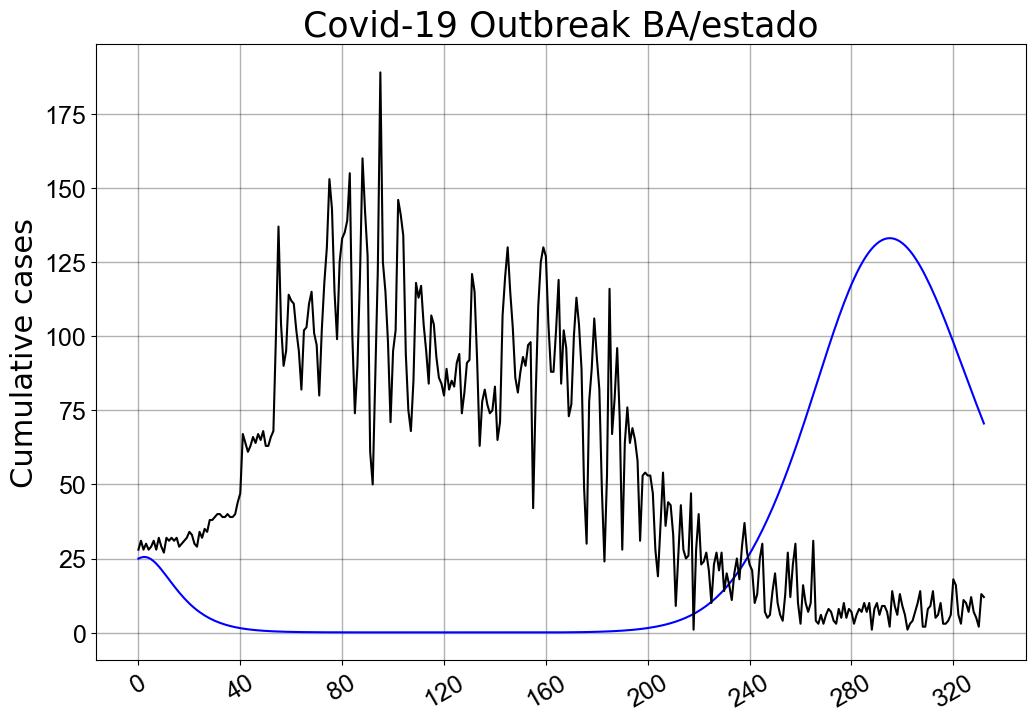

In [ ]:

#Save Fig
#fig.savefig(r"Fits\\"+s+file+".png",bbox_inches='tight')

qi = qs[:,-3] #Casos acumulados

#Plotting
#Create the figure and the graph.
fig, ax = pl.subplots(figsize=(12,8))

#Create a grid for visualization.
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

#Plot the points(Scatters). s=size, zorder= priority->(puttin g the points in at the front of everything).
ax.plot( np.diff(data_mortes),color='black',zorder=3,label='Reported data')

#Plot the fitted function as a line.
ax.plot(np.diff((N*qi)),color='blue',label='Fitted function')
ax.autoscale()

#Set the labels
ax.set_ylabel('Cumulative cases',fontsize=22)

#Set the title
ax.set_title('Covid-19 Outbreak '+s+'/'+file,fontsize=25)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

#Show Graph       
pl.show()


In [ ]:
best_pop    

array([1.30594354e-01, 1.70628343e+00, 3.60781180e+00, 2.69935884e+00,
       3.80564147e+01, 1.56628460e+02, 2.51688018e+02])

# Controle antes 

In [ ]:
# Condições iniciais antigas
D0          = 0;
N0          = 14930634;
R0          = 0;
H0          = 0;
U0          = 0;
V0          = 1000/N0;  
Rv0         = 0; 
Is0         = 2.015439771376298e-06;
Ia0         = 1.8028646508967777e-06;
Iav0        = 1.8028646508967777e-06; 
Isv0        = 1.8028646508967777e-06; 
E0          = 1.7639153732952095e-06;
Ev0         = 1.7639153732952095e-06;
S0          = (1-Is0-Ia0-E0);
Nw0         = 0;
NwV0        = 0;
HV0         = 0
UV0         = 0

condicoes_iniciais = [S0,E0,V0,Ev0,Ia0,Is0,Iav0,Isv0,H0,HV0,U0,UV0,R0,Rv0,D0,Nw0,NwV0];

In [ ]:
def seiihurd(y, t):
    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v = 0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    if t<20.178:
        beta=2.1317
    elif (t>=20.178-8) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 148):
        beta=1.1281
    else:
        beta=1

    # beta_v = beta*0.5
    beta_v = 0
    
    if t<100: #inicio_da_vacinacao:
        delta_av = 0
        delta_sv = 0
        phi_e = 0
        k_v=0
        p_v = 0
        gamma_av = 0
        gamma_sv = 0
        gamma_vu=0
        qsi_v = 0 
        eps=0
        mi_vh=0
        mi_vu=0
        gamma_vh=0
        tau=0
    else:
        delta_av = 0.31
        delta_sv = 0.31
        phi_e = 0.8
        k_v=1/3
        p_v = 0.1
        gamma_av = 1/3.5
        gamma_sv = 1/4
        gamma_vu=0.26
        qsi_v = 0.99
        eps=0.7
        mi_vh=0.03
        mi_vu=0.25
        gamma_vh=0.08
        tau=(6.6976e-05)*1.1
 
    # tau=novos_vacinados[int(t)]
    # N=14930634
    N=1
    psi=Psif[int(t)]

    S=y[0]
    E=y[1]
    Sv=y[2]
    Ev=y[3]
    Ia=y[4]
    Is=y[5]
    Iav=y[6]
    Isv=y[7]
    H=y[8]
    Hv=y[9]
    U=y[10]
    Uv=y[11]
    R=y[12]
    Rv=y[13]
    D=y[14]
    Nw=y[15]
    NwV=y[16]

    dSdt = -(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau/N
    dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E
    dSvdt = tau/N - (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - phi_e*eps*Sv
    dEvdt = (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vu*Hv
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_h*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H - phi_e*eps*Sv
    dRvdt = gamma_av*Iav + (1-h)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv)
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_h)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
    
    return [dSdt, dEdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, dRvdt, dDdt, dNwdt, dNwVdt]



In [ ]:
tempo = list(range(0, len(Psif[:636])))
resultados = odeint(seiihurd, condicoes_iniciais, tempo)
resultados_modelo = resultados

Sm = N0*resultados[:,0]
Em = N0*resultados[:,1]
Svm = N0*resultados[:,2]
Evm = N0*resultados[:,3]
Iam = N0*resultados[:,4]
Ism = N0*resultados[:,5]
Iavm = N0*resultados[:,6]
Isvm = N0*resultados[:,7]
Hm = N0*resultados[:,8]
Hvm = N0*resultados[:,9]
Um = N0*resultados[:,10]
Uvm = N0*resultados[:,11]
Rm = N0*resultados[:,12]
Rvm = N0*resultados[:,13]
Dm = N0*resultados[:,14]
Nwm = N0*resultados[:,15]
NwVm = N0*resultados[:,16]



634


ValueError: x and y must be the same size

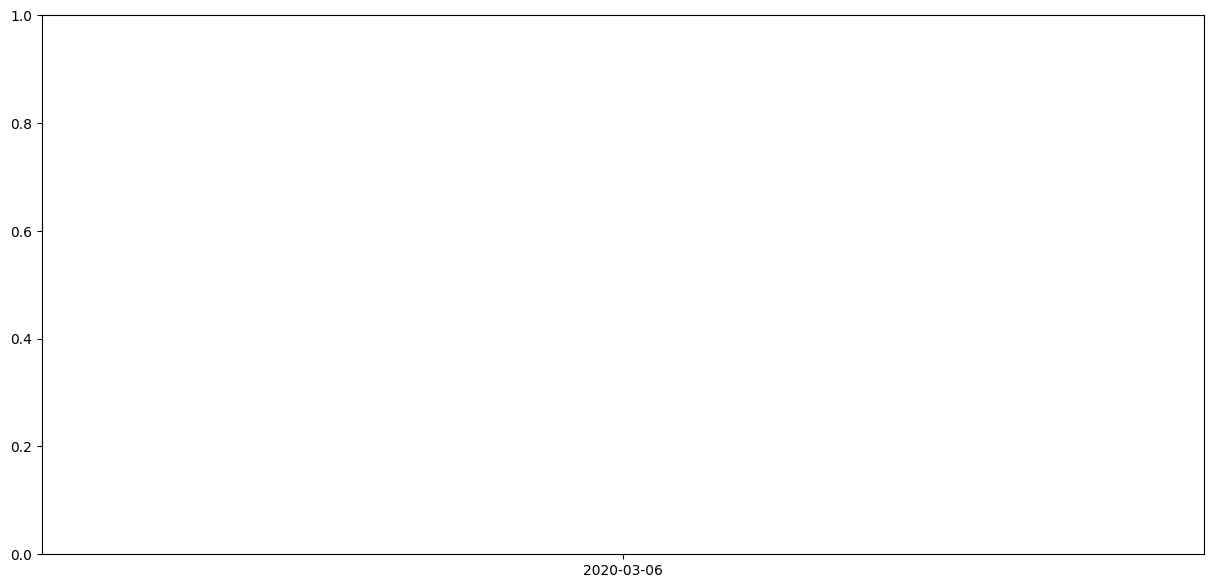

In [ ]:
df_all = Dados
data_mortes2=df_all.deaths.values
data_casos2 =df_all.cases.values

ts1=np.arange(len(Psif[:636])-1)
fig, ax = pl.subplots(figsize=(15,7))

Nwm_d = np.diff(Dm)

first_up = np.diff(Dm)[:210]
second_up = np.array(np.diff((N0*qi)))[65:]
deaths = np.append(first_up, second_up)

print(len(np.diff(data_mortes2)))

ax.scatter(df_all.date.values[:629], deaths[:635], color='g',zorder=1, linewidth=1)
ax.scatter(df_all.date.values[:634], np.diff(data_mortes2), s=35,color='black',zorder=3,label='Reported data')
ax.autoscale()

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

pl.show()

635


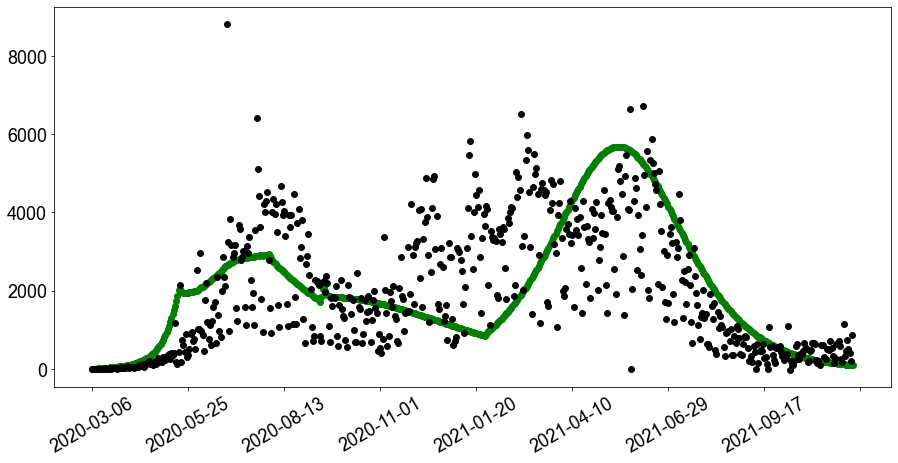

In [ ]:
ts1=np.arange(len(Psif[:675])-1)
fig, ax = pl.subplots(figsize=(15,7))

qcasos = qs[:,-2]

first_up = np.diff(Nwm)[:190]
second_up = np.array(np.diff((N0*qcasos)))
cases = np.append(first_up, second_up)

print(len(cases[:635]))

ax.scatter(df_all.date.values[:635], cases[:635], color='g',zorder=1, linewidth=1)
ax.scatter(df_all.date.values[:634], np.diff(data_casos2), s=35,color='black',zorder=3,label='Reported data')

ax.autoscale()

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

pl.show()


In [ ]:
best_pop

array([  1.59318589,   2.05572825,   3.70063071,  17.10104679,
       202.12034949])